# <span style="color: green; font-size: 40px; font-weight: bold;"> Projeto: Classificação de Imagens de Flores</span>

<br><br>

# Contexto

- Ana é uma botânica que trabalha em um grande jardim botânico, onde a variedade de flores é enorme. Catalogar e identificar essas flores manualmente é uma tarefa árdua e demorada. Para facilitar o trabalho, Ana decidiu usar a inteligência artificial para automatizar o processo de identificação de flores. Ela encontrou um conjunto de dados no Kaggle contendo imagens de diversas espécies de flores e decidiu criar um modelo de classificação de imagens utilizando redes neurais convolucionais (CNNs).

<br><br>

## Importando Pacotes

In [1]:
# Importando pacotes necessários
import os  # Para manipulação de diretórios e arquivos
import numpy as np  # Para manipulação de arrays e operações numéricas
import pandas as pd  # Para análise de dados e estruturas de dados
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator  # Para processamento de imagens e augmentação de dados
import matplotlib.pyplot as plt  # Para visualização de dados
import seaborn as sns  # Para visualização de dados
from sklearn.model_selection import train_test_split  # Para divisão dos dados em conjuntos de treino e teste
from sklearn.preprocessing import LabelEncoder  # Para codificação de rótulos
from tensorflow.keras.utils import to_categorical  # Para conversão de rótulos em one-hot encoding
from tensorflow.keras.models import Sequential  # Para construção do modelo de rede neural
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Camadas da rede neural
from tensorflow.keras.models import load_model  # Para salvar e carregar modelos

import pickle
import tensorflow as tf

2024-06-12 11:46:24.788319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 11:46:24.788333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<br><br>

## Download Conjunto de Dados

<br>

## Carregando Conjunto de Dados

- Carregando as imagens e rótulos do diretório do conjunto de dados.

In [2]:
def load_images(directory, target_size=(128, 128), max_images_per_class=1000):
    images = []
    labels = []
    label_count = {}
    
    for label in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, label)):
            label_count[label] = 0

    for label in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, label)):
            for file in os.listdir(os.path.join(directory, label)):
                if label_count[label] < max_images_per_class:
                    img_path = os.path.join(directory, label, file)
                    img = load_img(img_path, target_size=target_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(label)
                    label_count[label] += 1
                if len(images) >= max_images_per_class * len(label_count):
                    break
    return np.array(images), np.array(labels)

# Atualize o caminho do diretório após o download do dataset
data_dir = 'dados/flowers/flowers'
images, labels = load_images(data_dir, max_images_per_class=700)

# Verificar as dimensões dos dados
print(f'Total de imagens: {images.shape[0]}')
print(f'Dimensão de cada imagem: {images.shape[1:]}')
print(f'Total de rótulos: {len(labels)}')

Total de imagens: 3500
Dimensão de cada imagem: (128, 128, 3)
Total de rótulos: 3500


In [3]:
# Dicionário de tradução
translate = {
    "daisy": "margarida",
    "dandelion": "dente-de-leão",
    "rose": "rosa",
    "sunflower": "girassol",
    "tulip": "tulipa"
}

# Aplicar a tradução aos rótulos
labels_translated = np.array([translate[label] for label in labels])

<br>

## Análise dos Dados

- Realizando uma análise preliminar dos dados para verificar se estão corretos e prontos para o pré-processamento.

Total de imagens: 3500
Dimensão de cada imagem: (128, 128, 3)
Total de rótulos: 3500
dente-de-leão    700
girassol         700
rosa             700
margarida        700
tulipa           700
dtype: int64


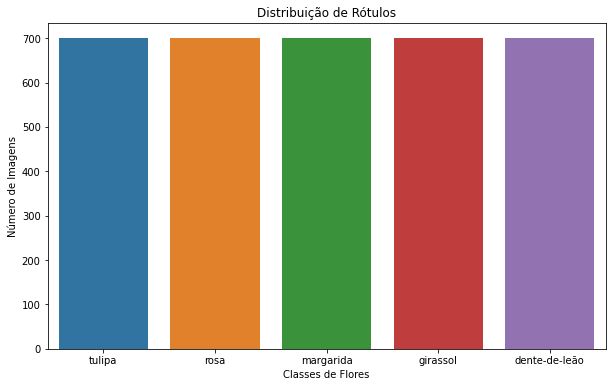

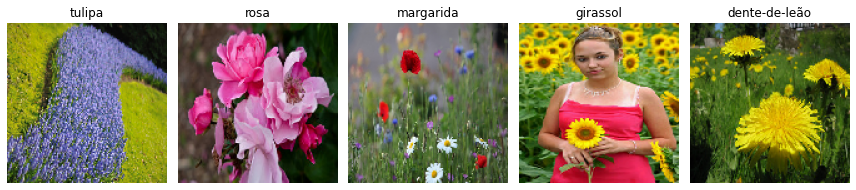

In [4]:
# Verificar as dimensões dos dados
print(f'Total de imagens: {images.shape[0]}')
print(f'Dimensão de cada imagem: {images.shape[1:]}')
print(f'Total de rótulos: {len(labels_translated)}')

# Verificar a distribuição dos rótulos
unique_labels, counts = np.unique(labels_translated, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]

# Mostrar value_counts() dos rótulos
labels_series = pd.Series(labels_translated)
print(labels_series.value_counts())

# Plotar a distribuição dos rótulos
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels[sorted_indices], y=counts[sorted_indices])
plt.title('Distribuição de Rótulos')
plt.xlabel('Classes de Flores')
plt.ylabel('Número de Imagens')
plt.show()

# Mostrar algumas imagens
plt.figure(figsize=(12, 8))
num_images_to_show = min(5, len(unique_labels))  # Ajuste para o número de classes
for i in range(num_images_to_show):
    label = unique_labels[sorted_indices[i]]
    label_indices = np.where(labels_translated == label)[0]
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(images[label_indices[0]].astype('uint8'))
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

<br>

## Pré-processamento de Dados
- **Carregando e rotulando as imagens**: Utilizamos **LabelEncoder** para transformar os rótulos de texto em rótulos numéricos.
- **Dividindo os dados em treino e teste**: Utilizamos **train_test_split** para dividir os dados em conjuntos de treino (80%) e teste (20%).
- **Normalizando os dados de entrada**: As imagens são normalizadas dividindo os valores dos pixels por 255.0, colocando-os na faixa de 0, 1.
- **Codificando os rótulos em one-hot**: Os rótulos numéricos são convertidos em uma representação one-hot, essencial para a camada de saída do modelo de classificação.
<br><br>
Este bloco de código garante que os dados estejam preparados adequadamente para o treinamento do modelo de aprendizado de máquina, melhorando a eficiência e a precisão do modelo.

In [5]:
# Dividindo os dados em treino e teste e normalizando as imagens
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_translated)

# Salvar a ordem dos rótulos
with open('modelos_imagens/label_encoder_classes.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_, f)

X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Verificar as dimensões dos dados de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Normalizar os dados de entrada
X_train = X_train / 255.0
X_test = X_test / 255.0

# Codificar os rótulos em one-hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(2800, 128, 128, 3)
(700, 128, 128, 3)
(2800,)
(700,)


<br>

## Criação, Compilação e Treinamento do Modelo

- Construímos o modelo de rede neural convolucional (CNN) utilizando Keras.
- Compilamos o modelo com o otimizador Adam e a função de perda categorical crossentropy.
- A técnica de **augmentação** de dados gera novas imagens a partir das imagens existentes, aumentando o tamanho efetivo do dataset sem a necessidade de coletar novas imagens reais. Isso ajuda a evitar overfitting, especialmente quando o dataset original é pequeno.
- Treinamos o modelo com os dados de treinamento e validamos com os dados de teste.

In [6]:
# Criação do Modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_translated)), activation='softmax')  # Corrigido para corresponder ao número de classes
])

# Compilação do Modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentação de Dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Treinando o Modelo
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=12, validation_data=(X_test, y_test))

print(history)

2024-06-11 16:40:04.338518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-11 16:40:04.338539: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-11 16:40:04.338552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eduardo-Inspiron-15-3520): /proc/driver/nvidia/version does not exist
2024-06-11 16:40:04.338711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 16:40:04.923209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None o

Epoch 1/12
88/88 [==============================] - ETA: 0s - loss: 1.4240 - accuracy: 0.4039

2024-06-11 16:40:28.624710: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 137625600 exceeds 10% of free system memory.


88/88 [==============================] - 25s 281ms/step - loss: 1.4240 - accuracy: 0.4039 - val_loss: 1.1938 - val_accuracy: 0.5229
Epoch 2/12
88/88 [==============================] - 28s 316ms/step - loss: 1.1052 - accuracy: 0.5486 - val_loss: 1.0904 - val_accuracy: 0.5829
Epoch 3/12
88/88 [==============================] - 28s 315ms/step - loss: 1.0092 - accuracy: 0.6025 - val_loss: 1.0276 - val_accuracy: 0.5900
Epoch 4/12
88/88 [==============================] - 28s 319ms/step - loss: 0.9274 - accuracy: 0.6357 - val_loss: 1.0735 - val_accuracy: 0.5986
Epoch 5/12
88/88 [==============================] - 27s 311ms/step - loss: 0.8875 - accuracy: 0.6604 - val_loss: 0.9267 - val_accuracy: 0.6643
Epoch 6/12
88/88 [==============================] - 28s 321ms/step - loss: 0.8526 - accuracy: 0.6789 - val_loss: 0.9399 - val_accuracy: 0.6643
Epoch 7/12
88/88 [==============================] - 28s 317ms/step - loss: 0.8263 - accuracy: 0.6814 - val_loss: 0.8541 - val_accuracy: 0.6629
Epoch 8/12

<br>

## Avaliação do Modelo

- Avaliamos o desempenho do modelo utilizando os dados de teste.

In [15]:
# Avaliação
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

 1/22 [>.............................] - ETA: 2s - loss: 0.8249 - accuracy: 0.6250

2024-06-11 16:50:52.590269: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 137625600 exceeds 10% of free system memory.


22/22 [==============================] - 1s 57ms/step - loss: 0.9525 - accuracy: 0.6614
Test accuracy: 0.6614285707473755


<br>

## Salvando e Carregando o Modelo

- Salvamos o modelo treinado em um arquivo e carregamos o modelo para uso futuro.

In [2]:
# Salvar o modelo
# model.save('modelos_imagens/flower_classifier_model.h5')

# Carregar o modelo
model = load_model('modelos_imagens/flower_classifier_model.h5')

2024-06-12 11:46:35.934305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-12 11:46:35.934360: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-12 11:46:35.934403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eduardo-Inspiron-15-3520): /proc/driver/nvidia/version does not exist
2024-06-12 11:46:35.934838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model

<br>

## Previsões com Novas Imagens

- Utilizamos o modelo para prever a classe de novas imagens. As novas imagens também precisam ser pré-processadas antes de serem passadas para o modelo.

In [7]:
def predict_image(image_path, model, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Exemplo de uso
image_path = 'novas_imagens/rosa.jpeg'
print(predict_image(image_path, model))

NameError: name 'label_encoder' is not defined

In [10]:
def predict_image(image_path, model, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Exemplo de uso
image_path = 'novas_imagens/mar.jpeg'
print(predict_image(image_path, model))

margarida


<br><br>

### Resumo
- Este projeto orienta você através das etapas para criar um modelo de classificação de imagens de flores usando deep learning. Começamos verificando e instalando pacotes necessários, fornecemos o link para o download do conjunto de dados, realizamos uma análise preliminar para garantir a qualidade dos dados, e passamos pelo pré-processamento, construção, treinamento, avaliação e salvamento do modelo. No final, mostramos como prever a classe de novas imagens, garantindo que elas sejam pré-processadas adequadamente antes de serem passadas para o modelo.

<br><br><br><br>

# <span style="color: green; font-size: 40px; font-weight: bold;"> INTERFACE: Classificação de Imagens de Flores</span>

<br><br>

# Versão 1

- Usando **Jupyter Widgets**.

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import io
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
# Função para pré-processamento da imagem
def preprocess_image(image_content, target_size=(128, 128)):
    img = Image.open(io.BytesIO(image_content))
    img_resized = img.resize(target_size)
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# Carregar a ordem dos rótulos
with open('modelos_imagens/label_encoder_classes.pkl', 'rb') as f:
    classes = pickle.load(f)

# Criar o Título
title = widgets.HTML("<h1>Classificação de Imagens de Flores</h1>")
display(title)

# Campo para Upload de Imagem
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
display(file_upload)

# Botão de Classificação (Desabilitado Inicialmente)
classify_button = widgets.Button(description="Classificar")
classify_button.disabled = True
display(classify_button)

# Função para Habilitar o Botão Após Upload
def on_upload_change(change):
    if file_upload.value:
        classify_button.disabled = False

file_upload.observe(on_upload_change, names='value')

# Área de Exibição de Resultados
output = widgets.Output()
display(output)

# Função de Classificação e Exibição
def classify_image(b):
    with output:
        clear_output()
        # Carregar a imagem
        uploaded_file = list(file_upload.value.values())[0]
        img_array, img = preprocess_image(uploaded_file['content'])
        
        # Carregar o modelo
        model = load_model('modelos_imagens/flower_classifier_model.h5')
        
        # Realizar a classificação
        prediction = model.predict(img_array)
        confidence = np.max(prediction) * 100
        result = classes[np.argmax(prediction)]
        
        # Exibir a imagem e a classificação
        display(img)
        display(widgets.HTML(f"<h2>Este modelo calculou que tem {confidence:.1f}% de chance dessa flor ser {result}.</h2>"))
        display(widgets.HTML(f"<h2>Classificação: {result}</h2>"))
        
        # Limpar o upload de imagem e desabilitar o botão
        file_upload.value.clear()
        classify_button.disabled = True
        
classify_button.on_click(classify_image)

HTML(value='<h1>Classificação de Imagens de Flores</h1>')

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Classificar', disabled=True, style=ButtonStyle())

Output()

<br><br>

====================================================================================================================

<br><br>

# Versão 2

- Versão mais elaborada usando o **Streamlit**.

In [6]:
import streamlit as st
from PIL import Image
import numpy as np
import io
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [11]:
# Função para pré-processamento da imagem
def preprocess_image(image_content, target_size=(128, 128)):
    img = Image.open(io.BytesIO(image_content))
    img_resized = img.resize(target_size)
    img_array = img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# Título da Aplicação
st.title("Classificação de Imagens de Flores")

# Carregar a ordem dos rótulos
with open('modelos_imagens/label_encoder_classes.pkl', 'rb') as f:
    classes = pickle.load(f)

# Upload de Imagem
uploaded_file = st.file_uploader("Escolha uma imagem de flor", type=["jpg", "jpeg", "png"])

# Botão de Classificação (Desabilitado Inicialmente)
if uploaded_file is not None:
    classify_button = st.button("Classificar")
    
    if classify_button:
        # Carregar a imagem
        img_array, img = preprocess_image(uploaded_file.read())
        
        # Carregar o modelo
        model = load_model('modelos_imagens/flower_classifier_model.h5')
        
        # Realizar a classificação
        prediction = model.predict(img_array)
        confidence = np.max(prediction) * 100
        result = classes[np.argmax(prediction)]
        
        # Exibir a imagem e a classificação
        st.image(img, caption='Imagem carregada', use_column_width=True)
        st.write(f"**Este modelo calculou que tem {confidence:.1f}% de chance dessa flor ser {result}.**")



<br><br>

# Importante

- Executar o comando **streamlit run app.py** no terminal da pasta onde **app.py** foi salvo.

In [8]:
!ls

01-Mini-Projeto_-_Construcao_Treinamento_Avaliacao_e_Selecao_de_Modelos_Para_Classificacao.ipynb
01-Mini-Projeto_-_Construcao_Treinamento_Avaliacao_e_Selecao_de_Modelos_Para_Regressao.ipynb
10.Projeto_Imagens_Veiculos.ipynb
1.Projeto_Regressao_-_Prevendo_Valor_Propriedades_Imobiliarias.ipynb
2.Projeto_Classificacao_-_Fraude_em_Transacoes_Bancarias.ipynb
3.Projeto_Regressao_-_Concrete_Compressive_Strength.ipynb
4.Projeto_Classificacao_-_Adult_Census_Income.ipynb
5.Projeto_Regressao_-_Wine_Quality.ipynb
6.Projeto_Classificacao_-_Heart_Disease.ipynb
7.Projeto_Imagens_Animais.ipynb
8.Projeto_Imagens_Frutas.ipynb
9.Projeto_Imagens_Flores.ipynb
app.py
catboost_info
dados
modelos_imagens
novas_imagens
requirements.txt
tabela_dados.html


<br><br><br>

# FIM